# Úkol č. 1 - redukce dimenzionality a binární klasifikace

  * **Deadline je 22. 4. 2024, 23:59:59**, pokud odevzdáte úkol do 29. 4. 2024, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * Experimentujte se standardizací/normalizací dat.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.


  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky a pokuste modely vylepšit
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [16]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
import random

from matplotlib import pyplot as plt

random_seed = 42

In [2]:
### odtud už je to Vaše
df_data = pd.read_csv('train.csv')

Podivame se nejprve na surova data - vidime ze prvni sloupec jsou labely, dalsi sloupce jsou pixely. Ukazeme si prvnich nekolik obrazku a vybereme nekolik nahodny pixelu, abychom videli jak vypadaji data v tabulce

In [3]:
n = 5
np.random.seed(random_seed)
random_indices = np.random.choice(range(1, df_data.shape[1]), size=n, replace=False)
selected_indices = np.append(0, random_indices)
selected_columns = df_data.head().iloc[:, selected_indices]
display(selected_columns)

,label,pixel599,pixel591,pixel210,pixel638,pixel175
0,1,247,0,232,0,0
1,0,90,0,193,0,0
2,1,151,0,190,1,0
3,0,185,0,168,15,0
4,1,0,0,10,0,0


Lets print some images

In [17]:
def split_data(data):
    print(f'Data shape: {data.shape}')
    labels = data['label']
    images = data.drop('label', axis=1)
    X_train, X_rest, y_train, y_rest = train_test_split(images, labels, test_size=0.4, random_state=random_seed)
    X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.6, random_state=random_seed)
    print(f"Train shape: {X_train.shape}")
    print(f"Validation shape: {X_val.shape}")
    print(f"Test shape: {X_test.shape}")
    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_data)

Data shape: (2400, 785)
Train shape: (1440, 784)
Validation shape: (576, 784)
Test shape: (384, 784)


In [182]:
def draw_images(images, y, shape, scale=1, rd_seed=None):
    max_images = 2 * shape[0] * shape[1]
    images_sample = images.sample(n=max_images, random_state=rd_seed)
    labels_sample = y[images_sample.index]

    labels = labels_sample.to_numpy()
    images = images_sample.to_numpy()

    fig = plt.figure(figsize=(scale * 2 * shape[1], scale * 2 * shape[0]), constrained_layout=True)
    i = 0
    while i < max_images and i < images.shape[0]:
        ax_hist = fig.add_subplot(2 * shape[0], 2 * shape[1], i + 1)
        ax_hist.hist(images[i], bins=256)
        ax_hist.set_yscale('log')
        ax_hist.set_ylabel("Count (log scale)")
        ax_hist.set_xlabel("Pixel value")

        ax_image = fig.add_subplot(2 * shape[0], 2 * shape[1], i + 2, xticks=[], yticks=[])
        image = images[i].reshape((28, 28))
        ax_image.imshow(image, cmap="Oranges", interpolation="nearest")
        ax_image.set_title("Trousers" if labels[i] == 0 else "Dress")

        i += 2

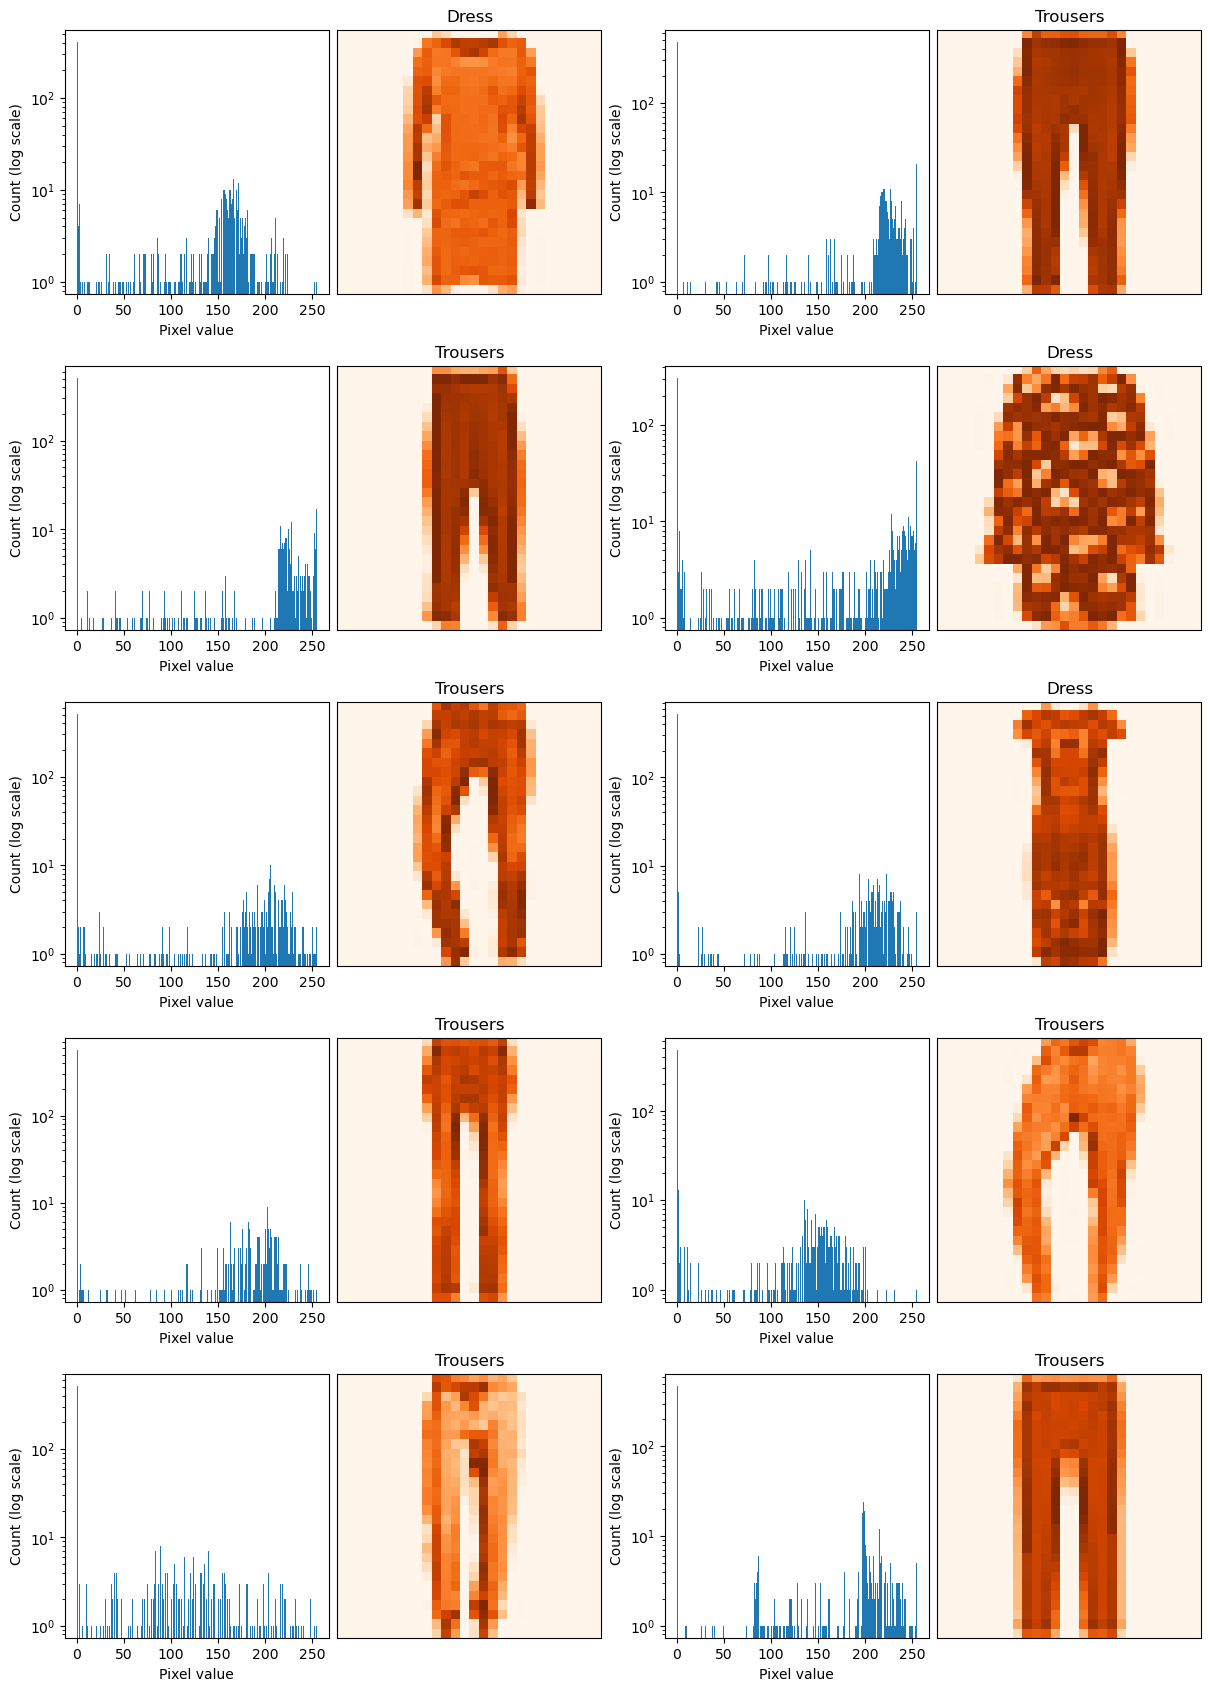

In [183]:
draw_images(images=X_train, y=y_train, scale=3, shape=(5, 2), rd_seed=random_seed)

Tady muzeme detailnejis se podivat na obrazek - konkretne kdy jake hodnoty nabyva

In [192]:
def inspect_image(images, labels, loc=None):
    if loc is not None:
        image_df = images.loc[loc]
        label = labels.loc[loc]
    else:
        image_df = images.sample(1, random_state=random_seed)
        label = labels[image_df.index].item()
    
    index = image_df.index[0]

    image_arr = image_df.to_numpy()
    display(pd.Series(image_arr[0]).describe())

    image = image_arr.reshape((28, 28))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4), constrained_layout=True)
    pos = ax1.imshow(image, cmap="Oranges", interpolation="nearest")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title(f"{'Trousers' if label == 0 else 'Dress'}\n{index}")
    fig.colorbar(mappable=pos)

    ax2.hist(image_arr[0], bins=256)
    ax2.set_yscale('log')
    ax2.set_title("Image histogram")
    ax2.set_ylabel("Count (log scale)")
    ax2.set_xlabel("Pixel value")

count    784.000000
mean      68.954082
std       80.621709
min        0.000000
25%        0.000000
50%        0.000000
75%      158.250000
max      255.000000
dtype: float64

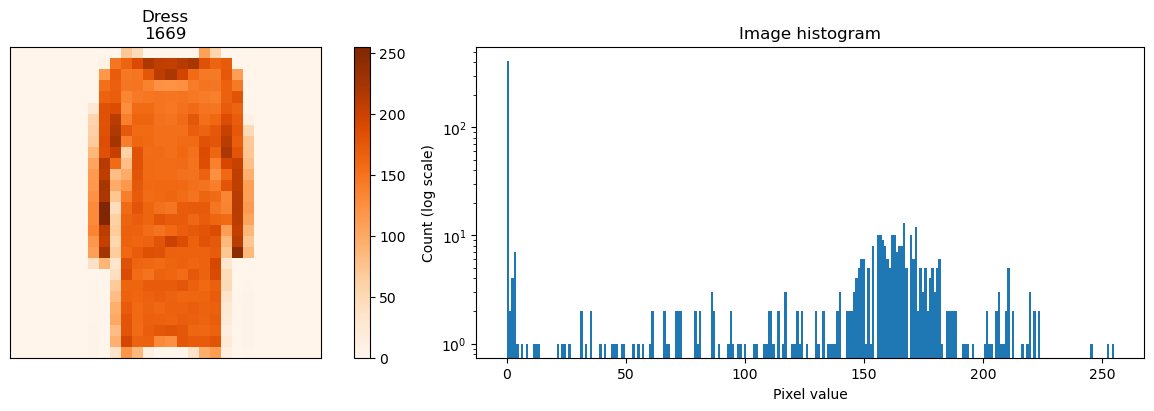

In [193]:
inspect_image(X_train, y_train)

To inspect data we can plot histograms for each image, or we can plot 

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 1862 to 860
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 8.6 MB
